In [1]:
from fastai.vision import *
from fastai.layers import *
from fastai.callbacks.hooks import *
import re
import cv2
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_csv_path = './train.csv'
train_data_path = './train_images'
test_csv_path = './test.csv'
test_data_path = './test_images'
unicode_csv_path = './unicode_translation.csv'

In [3]:
def _binarize(x):
    if x.shape[0] != 1:
        b = int(x.shape[1] * 2/3)
        b = b if b % 2 == 1 else b+1
        x = cv2.cvtColor(x.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
        x = (x*255).astype('uint8')
        x = cv2.adaptiveThreshold(x,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,b,2)
        x = torch.from_numpy(x/255).float()
        x = torch.unsqueeze(x, 0)
    return x
                           
binarize = TfmPixel(_binarize)

In [209]:
# Use for filtering specific folders
db = ImageList.from_folder('./char_images') \
            .filter_by_folder(['U+306B', 'U+306E', 'U+3057', 'U+3066', 'U+3068', 'U+3092', 'U+306F', 'U+304B', 'U+308A', 'U+306A']) \
            .split_by_rand_pct() \
            .label_from_folder() \
            .transform([[binarize()], [binarize()]], size=(64,64)) \
            .databunch(bs=256)

10

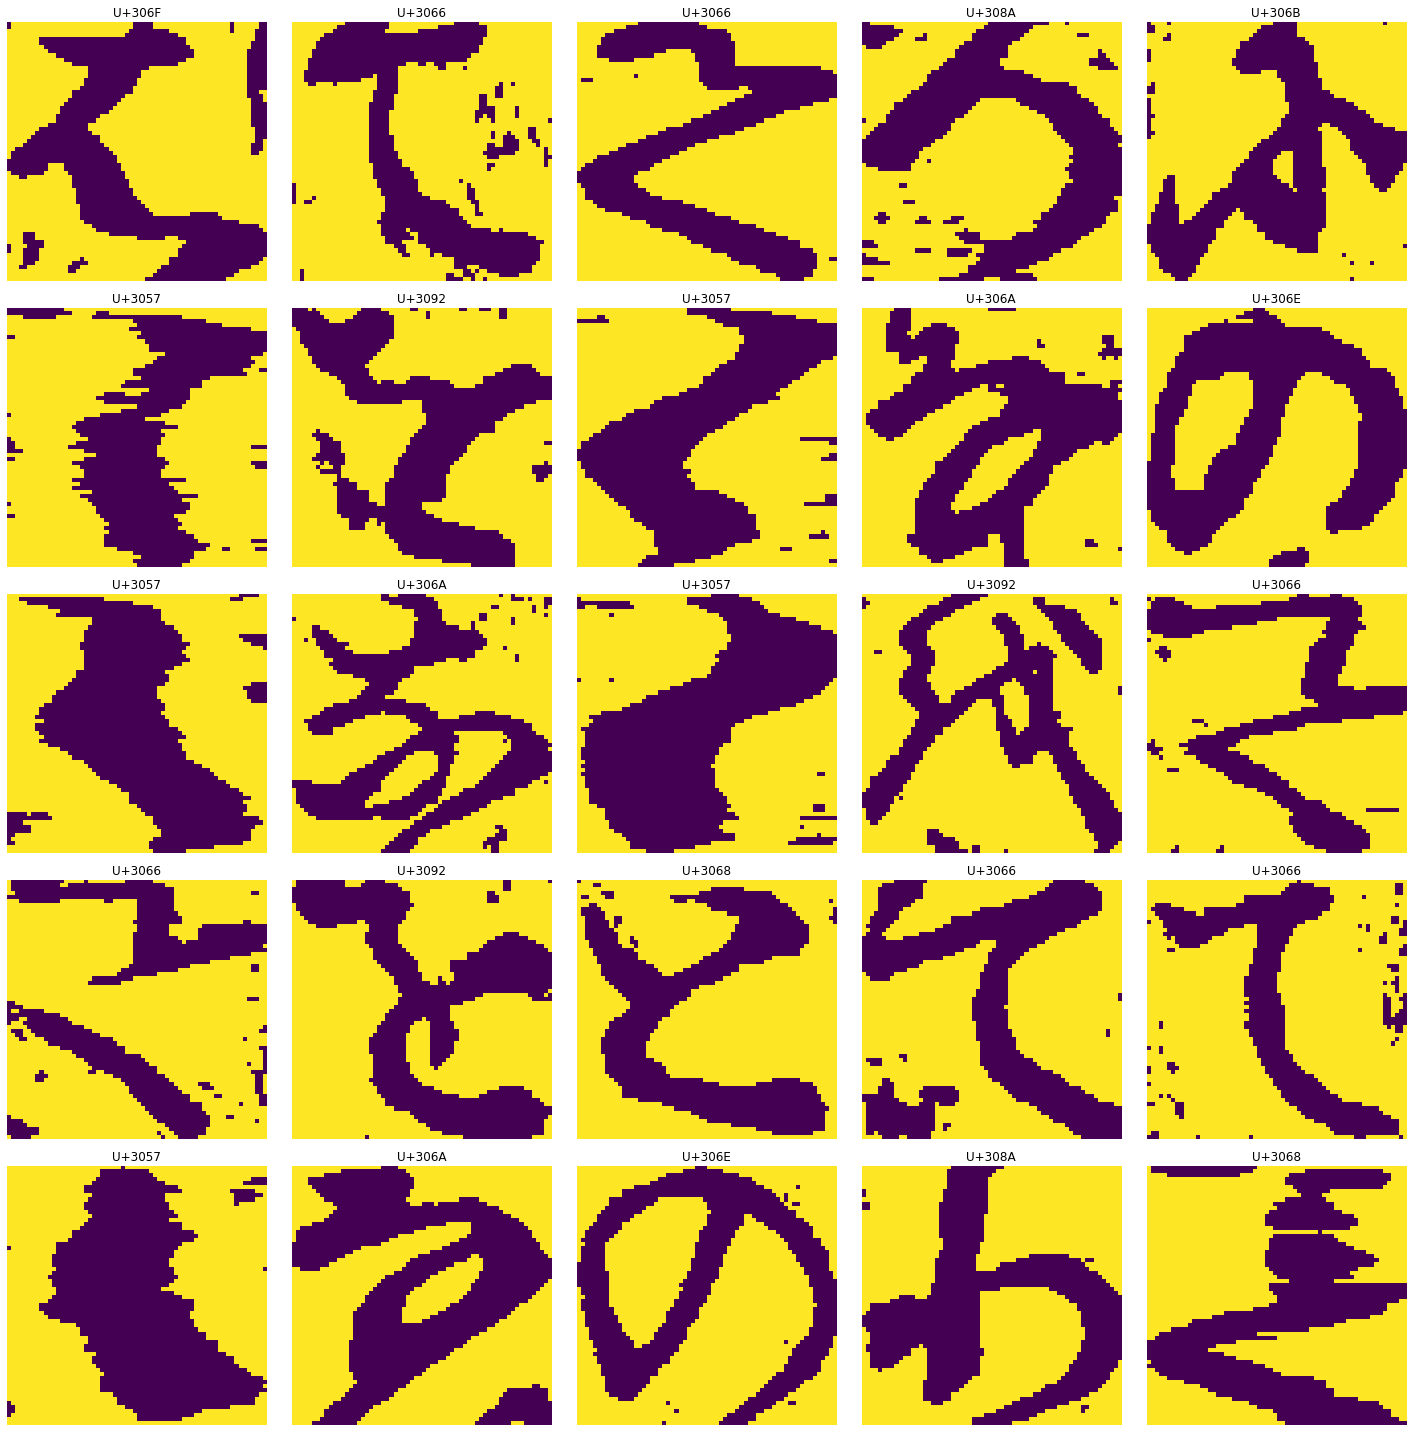

In [6]:
db.show_batch(rows=5)
db.c

In [5]:
loss = nn.CrossEntropyLoss()

class KuzuCharRec(nn.Module):
    
    def _conv2d_layer(self, ni, nf, stride=1):
        return nn.Sequential(
            conv2d(ni, nf, stride=stride, padding=1, bias=True),
            batchnorm_2d(nf),
            relu(True)
        )
    
    def __init__(self):
        super().__init__()
        starting_channels = 24
        self.conv_layers = []
        ch = starting_channels
        for i in range(0,9):
            if i%3 == 0:
                if i == 0:
                    self.conv_layers.append(self._conv2d_layer(1, ch, stride=2))
                else:
                    self.conv_layers.append(self._conv2d_layer(ch, ch*2, stride=2))
                    ch *= 2
            else:
                self.conv_layers.append(self._conv2d_layer(ch, ch))
        self.conv_layers = nn.Sequential(*self.conv_layers)
        self.pool1 = PoolFlatten()
        self.lin = nn.Sequential(*bn_drop_lin(ch, db.c, p=0.25))
        
    def forward(self, xb):
        act1 = self.conv_layers(xb)
        act2 = self.pool1(act1)
        act3 = self.lin(act2)
        return act3

In [7]:
learn = Learner(db, KuzuCharRec(), loss_func=loss, metrics=accuracy)
print(learn.model)
print(learn.summary())

KuzuCharRec(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(48, 48, kernel_size=

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


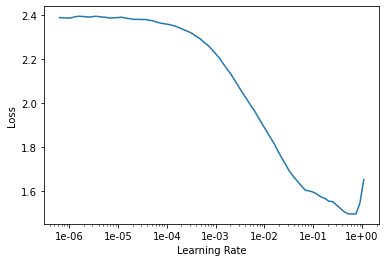

In [8]:
gc.collect()
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(10, slice(4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.122384,0.215184,0.934684,11:23
1,0.087386,0.358265,0.888514,00:29
2,0.070586,0.103984,0.968447,00:29
3,0.057131,0.051624,0.983754,00:29
4,0.039931,0.052883,0.984472,00:29
5,0.033446,0.049374,0.985218,00:29
6,0.024007,0.038971,0.988617,00:30
7,0.015254,0.036036,0.989832,00:30
8,0.010714,0.035202,0.990468,00:30
9,0.006419,0.034818,0.990661,00:30


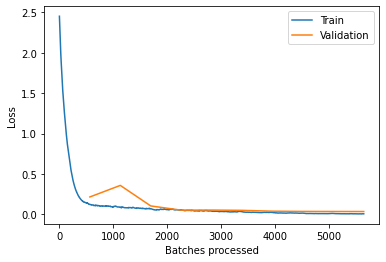

In [10]:
learn.recorder.plot_losses()

In [14]:
learn.save('rec10', return_path=True)

PosixPath('char_images/models/rec10.pth')

In [8]:
learn = learn.load('rec10')

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

In [10]:
loss,ind = interp.top_losses()

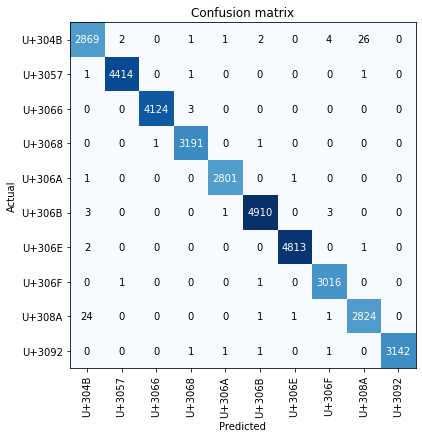

In [11]:
interp.plot_confusion_matrix(figsize=(6,6))

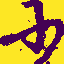

In [210]:
x, y = db.valid_ds[0]
x

In [211]:
y

Category 5

In [212]:
xb, _ = db.one_item(x)
xb_im = Image(xb[0])
xb = xb.cuda()

In [213]:
xb.shape

torch.Size([1, 1, 64, 64])

In [214]:
m = learn.model.eval()

In [215]:
def hook_final(xb):
    with hook_output(m.conv_layers) as hook:
        preds = m(xb)
    return hook

In [216]:
hook = hook_final(xb)

In [217]:
kern_out = hook.stored[0].cpu()

In [218]:
heatmap = kern_out.mean(0)

In [219]:
heatmap.shape

torch.Size([8, 8])

In [220]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax, cmap='autumn')
    ax.imshow(hm, alpha=0.6, extent=(0,64,64,0),
              interpolation='spline36', cmap='winter');

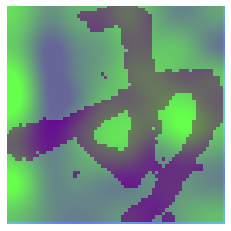

In [221]:
show_heatmap(heatmap)

In [223]:
doc(learn.fit_one_cycle)

fit_one_cycle [source] [test] fit_one_cycle ( learn : Learner , cyc_len : int , max_lr : Union [ float , Collection [ float ], slice ]= slice(None, 0.003, None) , moms : Point = (0.95, 0.85) , div_factor : float = 25.0 , pct_start : float = 0.3 , final_div : float = None , wd : float = None , callbacks : Optional [ Collection [ Callback ]]= None , tot_epochs : int = None , start_epoch : int = None ) 
 
 × Tests found for fit_one_cycle : pytest -sv tests/test_train.py::test_fit_one_cycle [source] To run tests please refer to this guide . Fit a model following the 1cycle policy. 
 Show in docs